In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

In [2]:
import numpy as np
from astropy.timeseries import LombScargle
from scipy import optimize

def amplitude_spectrum(t, y, fmin=None, fmax=None, freq=None, oversample_factor=10.0):
    """ 
    Calculates the amplitude spectrum of a given signal
    
    Parameters
    ----------
        t : `array`
            Time values 
        y : `array`
            Flux or magnitude measurements
        fmin : float (default None)
            Minimum frequency to calculate spectrum. Defaults to df
        fmax : float
            Maximum frequency to calculate spectrum. Defaults to Nyquist.
        oversample_factor : float
            Amount by which to oversample the spectrum. Defaults to 10.
    """
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult
    if freq is None:
        freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp


def estimate_frequencies(
    x, y, fmin=None, fmax=None, max_peaks=3, oversample=4.0, optimize_freq=True
):
    """
    Attempts to pick out the best frequencies
    for use with phase modulation. 
    Parameters
    ----------
    x : float, optional
        Number of tuning steps for the sampler (default 3000)
    y : float, optional
        Number of samples from which to populate the trace (default 3000)
    fmin : bool, optional
        If set to True, the sampler will optimize the model before
        attempting to sample. If False (default), the sampler will
        initialise at the testpoints of your priors.
    fmax : float, optional
        The target acceptance ratio of the NUTS sampler (default 0.9).
    max_peaks : int
        Maximum number of frequencies to return (default 3)
    oversample : float
        Oversample factor for the spectrum (default 4.)
    optimize_freq : bool
        Whether to optimize the frequencies according to the
        Maelstrom model using Scipy.optimize (default True)
    Returns
    -------
    peaks : `numpy.ndarray`
        Array of frequencies of length `max_peaks`
    """
    tmax = x.max()
    tmin = x.min()
    dt = np.median(np.diff(x))
    df = 1.0 / (tmax - tmin)
    ny = 0.5 / dt

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = ny

    freq = np.arange(fmin, fmax, df / oversample)
    power = LombScargle(x, y).power(freq)

    # Find peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power) - 1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for j in range(max_peaks):
        i = peak_inds[0]
        freq0 = freq[i]
        alias = 2.0 * ny - freq0

        m = np.abs(freq[peak_inds] - alias) > 25 * df
        m &= np.abs(freq[peak_inds] - freq0) > 25 * df

        peak_inds = peak_inds[m]
        peaks.append(freq0)
    peaks = np.array(peaks)

    if optimize_freq:

        def chi2(nu):
            arg = 2 * np.pi * nu[None, :] * x[:, None]
            D = np.concatenate([np.cos(arg), np.sin(arg), np.ones((len(x), 1))], axis=1)

            # Solve for the amplitudes and phases of the oscillations
            DTD = np.matmul(D.T, D)
            DTy = np.matmul(D.T, y[:, None])
            w = np.linalg.solve(DTD, DTy)
            model = np.squeeze(np.matmul(D, w))

            chi2_val = np.sum(np.square(y - model))
            return chi2_val

        res = optimize.minimize(chi2, [peaks], method="L-BFGS-B")
        return res.x
    else:
        return peaks
    
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        y : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag, ft_real))
    return phase

def get_time_delay(time, flux, freq, segment_size=10.):
    """ 
    Calculates the time delay signal, splitting the light curve into 
    chunks of width segment_size. A smaller segment size will increase
    the scatter of the time delay signal, especially for low frequencies.

    Parameters
    ----------
    segment_size : `float`
        Segment size in which to separate the light curve, in units of
        the light curve time. For example, the default segment size of 10 
        will separate a 1000 d long light curve in 100 segments of 10 d
        each.

    Returns
    -------
    time_midpoint : `numpy.ndarray`
        Midpoints of time for each segment in the light curve
    time_delay: `numpy.ndarray`
        Values of the extracted time delay in each segment.
    """
    uHz_conv = 1e-6 * 24 * 60 * 60
    time_0 = time[0]
    time_slice, mag_slice, phase = [], [], []
    time_delays, time_midpoints = [], []

    # Iterate over lightcurve
    for t, y in zip(time, flux):
        time_slice.append(t)
        mag_slice.append(y)

        # In each segment
        if t - time_0 > segment_size:
            # Append the time midpoint
            time_midpoints.append(np.mean(time_slice))

            # And the phases for each frequency
            phase.append(dft_phase(time_slice, mag_slice, freq))
            time_0 = t
            time_slice, mag_slice = [], []

    phase = np.array(phase).T
    # Phase wrapping patch
    for ph, f in zip(phase, freq):
        ph = np.unwrap(ph)
        ph -= np.mean(ph)

        td = ph / (2 * np.pi * (f / uHz_conv * 1e-6))
        time_delays.append(td)
    time_delays = np.array(time_delays)
    return np.array(time_midpoints), np.array(time_delays)

In [8]:
lc = lk.search_lightcurve('KIC 9651065', mission='Kepler', cadence='long').download_all().stitch().remove_nans()

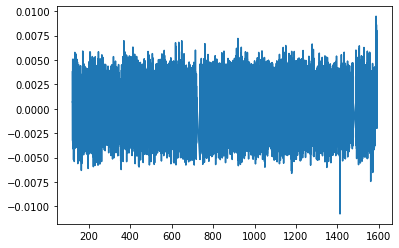

In [21]:
t, y = lc.time.value, lc.flux.value - 1.
plt.plot(t, y)

In [53]:
f, a = amplitude_spectrum(x, y, fmax=48)

freqs = estimate_frequencies(x, y, fmax=40, fmin=10, max_peaks=5)
amps = []
for freq in freqs:
    sc = LombScargle(t, y).power(freq, method="fast", normalization="psd")
    fct = np.sqrt(4.0 / len(t))
    amps.append(np.sqrt(sc) * fct)

amps = np.array(amps)
# plt.plot(f, a)
# plt.plot(freqs, amps, 'v', c='r')
# for f in freq:
#     plt.axvline(f, c='r')

In [54]:
import seaborn as sns
colors = np.array(sns.color_palette('Oranges', n_colors=len(freqs)))

In [59]:
plt.style.use('science')

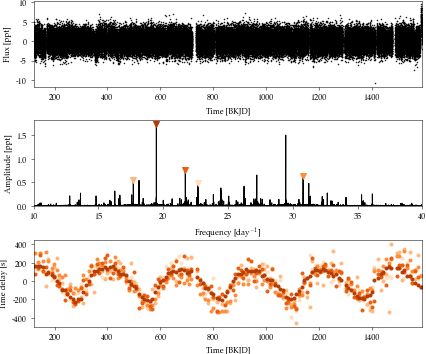

In [80]:
fig, axes = plt.subplots(3,1, figsize=[6., 5], constrained_layout=True)

ax = axes[0]
ax.plot(x, y*1e3, '.k', markersize=1, rasterized=True)
ax.set_xlabel('Time [BKJD]')
ax.set_ylabel('Flux [ppt]')
ax.set_xlim(x[0], x[-1])

ax = axes[1]
ax.plot(f, a * 1e3, 'k')
ax.set_xlim(10, 40)
ax.set_ylim(0, None)
ax.set_xlabel(r'Frequency [day$^{-1}$]')
ax.set_ylabel('Amplitude [ppt]')

colors = np.array(sns.color_palette('Oranges', n_colors=len(freqs)))[::-1]
for i in range(len(freqs)):
    ax.plot(freqs[i], amps[i] * 1e3, 'v', c=colors[i], rasterized=True)

ax = axes[2]
td_time, td = get_time_delay(x, y, freqs)
for i in range(len(freqs)):
    ax.plot(td_time, td[i], '.', c=colors[i], zorder=1-i, rasterized=True)
    
# ax.plot(td_time, np.median(td, axis=0), 'k')
ax.set_xlabel('Time [BKJD]')
ax.set_ylabel('Time delay [s]')
ax.set_xlim(x[0], x[-1])

plt.savefig('subdividing_example.pdf', dpi=300, bbox_inches='tight')

In [74]:
mean = np.median(td, axis=0)
mean

array([ 165.31356764,  160.52412227,  287.64385211,  111.58986448,
         91.58366921,   93.7349084 ,   93.41362465,   57.0383037 ,
         40.99137382,  -22.94762807,  -91.76541122,  -97.46248831,
       -138.04026818,  -96.5847347 , -200.96285773, -227.54957405,
       -190.79044431,  -75.31551932,  -76.96494567,  -82.95731472,
         -3.44216184,  119.66330701,   76.68355449,  148.54870206,
        128.75262091,  135.09620113,  149.73671246,  130.99806238,
        114.31914156,  108.84625772,  159.44087276,  105.07515731,
         81.60933049,  113.75534117,   37.97267039,  -77.93237612,
         -4.13731394,   -8.92448185,  -79.32246595, -136.50482125,
       -213.53706286, -192.46745643, -263.21283417, -269.67336473,
       -256.56568287, -115.85377775,  -98.29009944,   -1.69187316,
        -52.14893788,   24.8276069 ,   52.98078892,  102.70581632,
        111.92178187,  103.17866591,  124.9614612 ,   75.4279677 ,
        139.55324596,   92.46301399,   67.39191399,  133.88301